In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Data prepreparation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_csv('/content/drive/MyDrive/olist_new.csv')

In [4]:
df.shape

(115888, 38)

In [5]:
df.head(5)

,order_id,order_item_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,shipping_limit_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,...,day,quarter,dayofWeek,isweekend,is holiday,is Promoday,order_date,Difference_days,sellers_delay_days,day_of_week
0,2e7a8482f6fb09756ca50c10d7bfc047,1.0,shipped,2023-09-04 21:15:19,2023-10-07 13:18:03,2023-10-18 13:14:51,2023-10-26 18:25:19,NaN,2023-10-20,b7d76e111c89f7ebf14761390f0f7d17,...,4,3,0,0,False,0,2023-09-04,NaN,8.0,Monday
1,2e7a8482f6fb09756ca50c10d7bfc047,2.0,shipped,2023-09-04 21:15:19,2023-10-07 13:18:03,2023-10-18 13:14:51,2023-10-26 18:25:19,NaN,2023-10-20,b7d76e111c89f7ebf14761390f0f7d17,...,4,3,0,0,False,0,2023-09-04,NaN,8.0,Monday
2,e5fa5a7210941f7d56d0208e4e071d35,1.0,canceled,2023-09-05 00:15:34,2023-10-07 13:17:15,NaN,2023-09-19 00:15:34,NaN,2023-10-28,4854e9b3feff728c13ee5fc7d1547e92,...,5,3,1,0,False,0,2023-09-05,NaN,NaN,Tuesday
3,bfbd0f9bdef84302105ad712db648a6c,2.0,delivered,2023-09-15 12:16:38,2023-09-15 12:16:38,2023-11-07 17:11:53,2023-09-19 23:11:33,2023-11-09 07:47:38,2023-10-04,830d5b7aaa3b6f1e9ad63703bec97d23,...,15,3,4,0,False,0,2023-09-15,-37.0,-49.0,Friday
4,bfbd0f9bdef84302105ad712db648a6c,1.0,delivered,2023-09-15 12:16:38,2023-09-15 12:16:38,2023-11-07 17:11:53,2023-09-19 23:11:33,2023-11-09 07:47:38,2023-10-04,830d5b7aaa3b6f1e9ad63703bec97d23,...,15,3,4,0,False,0,2023-09-15,-37.0,-49.0,Friday


In [6]:
df.columns

Index(['order_id', 'order_item_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'shipping_limit_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_unique_id', 'customer_city',
       'customer_state', 'product_id', 'product_category_name', 'price',
       'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_score', 'seller_id',
       'seller_city', 'seller_state', 'calculated_total',
       'approval_pending_flag', 'Year', 'Month', 'day', 'quarter', 'dayofWeek',
       'isweekend', 'is holiday', 'is Promoday', 'order_date',
       'Difference_days', 'sellers_delay_days', 'day_of_week'],
      dtype='object')

In [7]:
df.isnull().sum()

,0
order_id,0
order_item_id,0
order_status,0
order_purchase_timestamp,0
order_approved_at,14
order_delivered_carrier_date,1206
shipping_limit_date,0
order_delivered_customer_date,2502
order_estimated_delivery_date,0
customer_unique_id,0


In [8]:
df.shape

(115888, 38)

In [9]:
# df.loc[df['is Promoday'] == 1, 'calculated_total'].sum()
df.drop(df[df['is Promoday'] == 1].index, inplace=True)

In [10]:
df=df[df['order_date'] < '2025-09-01']

In [11]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Workflow

## 1. MONTHLY AGGREGATION - PROPER FEATURE ENGINEERING
    
    Aggregate transactions to monthly level per category-state
    Enhanced with promotional intensity features
    

In [ ]:
def aggregate_to_monthly(df):

    # Define date column name for consistency
    DATE_COL = 'order_purchase_timestamp'

    # Create year-month for grouping and ensure it's datetime
    if not pd.api.types.is_datetime64_any_dtype(df[DATE_COL]):
        df[DATE_COL] = pd.to_datetime(df[DATE_COL])

    # Extract year-month for grouping
    df['year_month'] = df[DATE_COL].dt.to_period('M')

    # Aggregation by customer_state, product_category, year_month
    agg_dict = {
        'calculated_total': 'sum',  # TARGET
        'order_date': 'count',
        'price': ['mean', 'std', 'sum'],
        'freight_value': ['mean', 'sum'],
        'payment_installments': 'mean',
        'review_score': 'mean',
        'isweekend': 'sum',
        'is holiday': 'sum',
        'seller_state': 'nunique',
        'customer_city': 'nunique',
        'payment_type': 'nunique',
        'day': 'count'  # Days in month (for normalization)
    }

    df_monthly = df.groupby(['customer_state', 'product_category_name', 'year_month']).agg(agg_dict).reset_index()

    # Flatten columns
    df_monthly.columns = ['_'.join(col).strip('_') if col[1] else col[0]
                          for col in df_monthly.columns.values]

    # Rename 
    df_monthly = df_monthly.rename(columns={
        'calculated_total_sum': 'sales_amount',
        'order_date_count': 'order_count',
        'isweekend_sum': 'weekend_days',
        'is holiday_sum': 'holiday_days',
        'day_count': 'days_in_month'
    })

    # Extract temporal info
    df_monthly['year'] = df_monthly['year_month'].dt.year
    df_monthly['month'] = df_monthly['year_month'].dt.month
    df_monthly['quarter'] = df_monthly['year_month'].dt.quarter
    df_monthly['date'] = df_monthly['year_month'].dt.to_timestamp()

    # Sort
    df_monthly = df_monthly.sort_values(['customer_state', 'product_category_name', 'date'])

    print(f" Aggregated to {len(df_monthly):,} monthly records")
    print(f"Date range: {df_monthly['date'].min()} to {df_monthly['date'].max()}")
    print(f" Unique category-state combinations: {df_monthly.groupby(['customer_state', 'product_category_name']).ngroups}")

    return df_monthly

## 3. FEATURE ENGINEERING - LAG & ROLLING FEATURES (NO LEAKAGE)
   
    Create comprehensive feature set including:
    - Proper lag features (no leakage)
    - Promotional interaction terms
    - State/category specific features
    - Seasonality encoding
   

In [ ]:
def create_advanced_features(df_monthly):

    df = df_monthly.copy()
    group_cols = ['customer_state', 'product_category_name']

    # A. LAG FEATURES (n months)

    lag_cols = ['sales_amount', 'order_count']
    lags = [1]

    for col in lag_cols:
        if col in df.columns:
            for lag in lags:
                df[f'{col}_lag{lag}'] = df.groupby(group_cols)[col].shift(lag)

  
    # B. ROLLING STATISTICS (n month windows)
    windows = [2]
    for col in ['sales_amount', 'order_count']: #, 'promo_intensity'
        if col in df.columns:
            for window in windows:
                # Max
                df[f'{col}_roll_max_{window}m'] = df.groupby(group_cols)[col].transform(
                    lambda x: x.rolling(window, min_periods=1).max().shift(1)
                )
                # Median
                df[f'{col}_roll_median_{window}m'] = df.groupby(group_cols)[col].transform(
                    lambda x: x.rolling(window, min_periods=1).median().shift(1)
                )


    # C. DIFF FEATURES (Growth rates)

    df['sales_diff_1m_safe'] = df.groupby(group_cols)['sales_amount'].diff(1).shift(1)
    df['sales_diff_3m_safe'] = df.groupby(group_cols)['sales_amount'].diff(3).shift(1)

    # Growth rate (percentage change) - CORRECTED
    df['sales_growth_1m_safe'] = df.groupby(group_cols)['sales_amount'].pct_change(1).shift(1)


    # D. SEASONALITY FEATURES (Cyclical encoding)

    # Calendar features (known in advance, no leakage)
    df['calendar_days_in_month'] = df['date'].dt.days_in_month
    df['is_month_start'] = (df['date'].dt.day <= 7).astype(int)
    df['is_month_end'] = (df['date'].dt.day >= 23).astype(int)

    # Black Friday month indicator
    df['is_q4'] = (df['quarter'] == 4).astype(int)


    # E. TREND FEATURES

    # Linear trend per group (using expanding window to avoid leakage)
    def calc_expanding_trend(group):
        trends = []
        for i in range(len(group)):
            if i < 2:
                trends.append(0)
            else:
                x = np.arange(i)
                y = group['sales_amount'].iloc[:i].values
                if len(x) > 1 and np.std(x) > 0:
                    slope = np.polyfit(x, y, 1)[0]
                else:
                    slope = 0
                trends.append(slope)
        return pd.Series(trends, index=group.index)

    df['sales_trend'] = df.groupby(group_cols).apply(calc_expanding_trend).reset_index(level=[0, 1], drop=True)


    # F. HISTORICAL AGGREGATES (Expanding mean - no leakage)
    df['category_hist_med'] = df.groupby('product_category_name')['sales_amount'].transform(
        lambda x: x.expanding().median().shift(1)
    )
    df['state_hist_med'] = df.groupby('customer_state')['sales_amount'].transform(
        lambda x: x.expanding().median().shift(1)
    )
    df['group_hist_med'] = df.groupby(group_cols)['sales_amount'].transform(
        lambda x: x.expanding().median().shift(1)
    )

    # Historical max (captures peak performance)
    df['category_hist_max'] = df.groupby('product_category_name')['sales_amount'].transform(
        lambda x: x.expanding().max().shift(1)
    )
    df['group_hist_max'] = df.groupby(group_cols)['sales_amount'].transform(
        lambda x: x.expanding().max().shift(1)
    )


    # G. STATE-SPECIFIC FEATURES (SP dominates)

    df['is_sp'] = (df['customer_state'] == 'SP').astype(int)
    df['is_pr'] = (df['customer_state'] == 'PR').astype(int)
    df['is_mg'] = (df['customer_state'] == 'MG').astype(int)

    # H. HIGH-VALUE CATEGORY FLAGS
    high_value_cats = ['health_beauty', 'watches_gifts', 'bed_bath_table']
    df['is_high_value_category'] = df['product_category_name'].isin(high_value_cats).astype(int)
    # Volatility (coefficient of variation)
    df['sales_volatility'] = df.groupby(group_cols)['sales_amount'].transform(
        lambda x: x.rolling(6, min_periods=2).std().shift(1) / (x.rolling(6, min_periods=2).mean().shift(1) + 1)
    )

    print(f"Created {lags} lag periods for key features")
    print(f"Created {windows} rolling windows")
    print(f"Added seasonality encoding (sin/cos)")
    print(f"Added promotional interaction features (9 features)")
    print(f"Added state-specific features (SP, PR, MG)")
    print(f"Total features: {len(df.columns)}")

    return df

## 4. ENCODING CATEGORICAL FEATURES
    Encode categorical variables with frequency encoding

In [ ]:
def encode_categorical_features(df_monthly, categorical_cols=None):

    df = df_monthly.copy()

    if categorical_cols is None:
        categorical_cols = ['customer_state', 'product_category_name']

    encoders = {}

    for col in categorical_cols:
        if col in df.columns:
            # Frequency encoding
            freq_map = df[col].value_counts(normalize=True).to_dict()
            df[f'{col}_freq'] = df[col].map(freq_map)

            # Label encoding
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
            encoders[col] = le

            print(f"Encoded {col}: {df[col].nunique()} unique values")

    return df, encoders

##  5. TRAIN/TEST SPLIT (TIME-BASED)
    Time-based split with promotional period analysis


In [ ]:
def time_based_split(df, test_months=3, test_start_date=None):

    # Determine split date
    if test_start_date:
        split_date = pd.to_datetime(test_start_date)
        print(f"Using custom test start date: {split_date.strftime('%Y-%m')}")
    else:
        max_date = df['date'].max()
        split_date = max_date - pd.DateOffset(months=test_months)
        print(f"Using automatic split (last {test_months} months)")

    train = df[df['date'] < split_date].copy()
    test = df[df['date'] >= split_date].copy()

    print(f"Split date: {split_date.strftime('%Y-%m')}")
    print(f"Train set: {len(train):,} records ({train['date'].min().strftime('%Y-%m')} to {train['date'].max().strftime('%Y-%m')})")
    print(f"Test set: {len(test):,} records ({test['date'].min().strftime('%Y-%m')} to {test['date'].max().strftime('%Y-%m')})")

    return train, test, split_date

## 6. PREPARE FEATURES & TARGET
    Prepare X and y with log transformation

In [ ]:
def prepare_features_target(train, test, target_col='sales_amount'):

    # Exclude non-feature columns (keep safe historical features!)
    exclude_cols = [
        target_col, 'date', 'year_month',
        'customer_state', 'product_category_name',  # Original categorical
        'price_sum', 'freight_value_sum', 'order_count', 'payment_installments_mean',  # Current month aggregates
        'price_mean', 'price_std', 'freight_value_mean', 'review_score_mean', # Current month stats
        # !! Remove leakage features
        'days_in_month',  # This counts transactions, not calendar days
        'customer_city_nunique',  # Counts cities in current month
        'seller_state_nunique',  # Counts sellers in current month
        'payment_type_nunique',  # Counts payment types in current month
        'weekend_days',  # Counts weekend transactions in current month
        'holiday_days',  # Counts holiday transactions in current month
        'month_sin',
        'month_cos', 'quarter_sin','quarter_cos','is_november','is_december','month_index',
        'order_count_roll_mean_12m','sales_amount_roll_mean_12m','sales_amount_roll_mean_6m',
        'order_count_roll_mean_3m','order_count_roll_std_3m','sales_amount_roll_mean_3m',
        'sales_amount_roll_std_3m','sales_amount_roll_std_6m','sales_amount_roll_std_12m',
        'order_count_roll_mean_6m','order_count_roll_std_6m','order_count_roll_std_12m','is_month_start','is_month_end','is_q4',


    ]


    feature_cols = [col for col in train.columns if col not in exclude_cols]

    # Check NaN ratio before dropping
    print("\nChecking NaN values in features...")
    nan_counts = train[feature_cols].isna().sum()
    high_nan_features = nan_counts[nan_counts > len(train) * 0.5].index.tolist()

    if len(high_nan_features) > 0:
        print(f" Removing {len(high_nan_features)} features with >50% NaN values:")
        for feat in high_nan_features[:10]:  # Show first 10
            print(f"   - {feat}: {nan_counts[feat]}/{len(train)} NaN ({nan_counts[feat]/len(train)*100:.1f}%)")

        # Remove high-NaN features
        feature_cols = [col for col in feature_cols if col not in high_nan_features]

    # Fill remaining NaNs with 0 (for lag features at the start)
    train_clean = train.copy()
    test_clean = test.copy()

    train_clean[feature_cols] = train_clean[feature_cols].fillna(0)
    test_clean[feature_cols] = test_clean[feature_cols].fillna(0)

    print(f"\nFilled NaN values with 0 (safe for lag features)")
    print(f"Training samples: {len(train_clean):,}")
    print(f"Test samples: {len(test_clean):,}")

    # Prepare X and y
    X_train = train_clean[feature_cols]
    y_train = train_clean[target_col]
    X_test = test_clean[feature_cols]
    y_test = test_clean[target_col]

    # Check for infinite values and replace
    X_train = X_train.replace([np.inf, -np.inf], 0)
    X_test = X_test.replace([np.inf, -np.inf], 0)

    # Final check - ensure no NaN or inf remain
    if X_train.isna().any().any():
        print(" Warning: Some NaN values remain, filling with 0")
        X_train = X_train.fillna(0)
    if X_test.isna().any().any():
        print(" Warning: Some NaN values remain in test, filling with 0")
        X_test = X_test.fillna(0)

    # Log transformation (critical for skewed distribution)
    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)

    print(f"\nFeature matrix shape: {X_train.shape}")
    print(f"Number of features: {len(feature_cols)}")
    print(f"\nTarget statistics (original scale):")
    print(f"  Train - Mean: {y_train.mean():.2f}, Median: {y_train.median():.2f}")
    print(f"  Test  - Mean: {y_test.mean():.2f}, Median: {y_test.median():.2f}")

    metadata = {
        'feature_cols': feature_cols,
        'train_clean': train_clean,
        'test_clean': test_clean
    }

    return X_train, X_test, y_train, y_test, y_train_log, y_test_log, metadata

## 7. MODEL TRAINING
    Train regularized models to prevent overfitting
   

In [ ]:
def train_models(X_train, y_train_log, use_sample_weights=False, y_train_original=None):

    models = {}

    # Sample weights (Weighted Loss for Stability)
    sample_weights = None
    if use_sample_weights and y_train_original is not None:

        # Add 1 for stability (prevents zero sales from having zero weight)
        sample_weights = y_train_original + 1

        # Normalize the weights so they average to 1 (maintains training stability)
        sample_weights = sample_weights / sample_weights.sum() * len(sample_weights)

        print("Using sample weights (DIRECT value weighting for weighted loss)")

    # Random Forest (Less prone to overfitting)
    print("\nTraining Random Forest...")
    rf_model = RandomForestRegressor(
        n_estimators=300,
        max_depth=15,
        min_samples_split=20,
        min_samples_leaf=5,
        max_features= 'sqrt',
        n_jobs=-1,
        random_state=42
    )
    # The fit method applies the sample_weight to the loss function
    rf_model.fit(X_train, y_train_log, sample_weight=sample_weights)
    models['Random Forest'] = rf_model
    print(" Random Forest trained (regularized)")


    
    # XGBoost (HEAVILY REGULARIZED)
    print("\nTraining XGBoost (regularized)...")
    xgb_model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=5,             # Reduced from 8
        learning_rate=0.05,
        min_child_weight=5,      # Prevent overfitting
        gamma=0.1,               # Regularization
        subsample=0.7,           # Row sampling
        colsample_bytree=0.7,    # Column sampling
        reg_alpha=0.5,           # L1 regularization
        reg_lambda=1.0,          # L2 regularization
        random_state=42,
        n_jobs=-1
    )

    xgb_model.fit(X_train, y_train_log, sample_weight=sample_weights)
    models['XGBoost'] = xgb_model
    print("XGBoost trained (heavily regularized)")


    # LightGBM (REGULARIZED + Huber Loss for outliers)
    print("\nTraining LightGBM (regularized + robust loss)...")
    lgb_model = lgb.LGBMRegressor(
        n_estimators=300, #200
        max_depth=10, #9
        learning_rate=0.03,
        num_leaves=30, #20           # Reduced from 50
        min_child_samples=20,    # Prevent overfitting
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=0.3,           # L1
        reg_lambda=0.5,          # L2
        objective='huber',       # Robust to outliers (Black Friday)
        alpha=0.9,               # Huber parameter
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

    lgb_model.fit(X_train, y_train_log, sample_weight=sample_weights)
    models['LightGBM'] = lgb_model
    print("LightGBM trained (Huber loss for robustness)")

    return models

##8. MODEL EVALUATION
    Evaluate models with different metrics and includes the robust WMAPE metric.

In [ ]:
def calculate_wmape(y_true, y_pred):
    """
    WMAPE = SUM(|y_true - y_pred|) / SUM(|y_true|)
    """

    # Avoid division by zero if total true sales are zero (unlikely here)
    denominator = np.sum(np.abs(y_true))
    if denominator == 0:
        return np.nan # Or 0, depending on context. NaN is safer.

    numerator = np.sum(np.abs(y_true - y_pred))

    # WMAPE is a percentage, so multiply by 100
    return (numerator / denominator) * 100

def evaluate_models(models, X_train, X_test, y_train, y_test, y_train_log, y_test_log, metadata):

    results = []
    predictions = {}

    for name, model in models.items():
        # Predict
        y_train_pred_log = model.predict(X_train)
        y_test_pred_log = model.predict(X_test)

        # Back to original scale
        y_train_pred = np.expm1(y_train_pred_log)
        y_test_pred = np.expm1(y_test_pred_log)

        predictions[name] = {
            'train': y_train_pred,
            'test': y_test_pred
        }

    
        # Overall metrics
        train_mae = mean_absolute_error(y_train, y_train_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        train_r2 = r2_score(y_train, y_train_pred)
        train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
        train_wmape = calculate_wmape(y_train, y_train_pred) # NEW WMAPE

        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_r2 = r2_score(y_test, y_test_pred)
        test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
        test_wmape = calculate_wmape(y_test, y_test_pred) # NEW WMAPE

        results.append({
            'Model': name,
            'Train MAE': train_mae,
            'Train RMSE': train_rmse,
            'Train R²': train_r2,
            'Train MAPE': train_mape,
            'Train WMAPE': train_wmape, 
            'Test MAE': test_mae,
            'Test RMSE': test_rmse,
            'Test R²': test_r2,
            'Test MAPE': test_mape,
            'Test WMAPE': test_wmape,

        })

    results_df = pd.DataFrame(results).sort_values('Test RMSE')


    # Display Results
    print("\n" + "=" * 80)
    print("MODEL COMPARISON (sorted by Test RMSE)")
    print("=" * 80)

    # Define columns to display
    display_cols = [
        'Model', 'Train MAE', 'Train RMSE', 'Train R²' ,'Train WMAPE' ,'Test WMAPE', #
        'Test MAE', 'Test RMSE', 'Test R²'
    ]
    print(results_df[display_cols].to_string(index=False, float_format="{:.4f}".format))

    # Best model
    best_model = results_df.iloc[0]['Model']
    print(f"\nRECOMMENDED MODEL: {best_model}")
    print(f"   → Overall Test RMSE: {results_df.iloc[0]['Test RMSE']:.2f}")
    print(f"   → Overall Test WMAPE: {results_df.iloc[0]['Test WMAPE']:.2f}%") # Changed to WMAPE

    # Overfitting check (using WMAPE for a stable comparison)
    print(f"\nOverfitting Analysis ({best_model}):")
    train_wmape = results_df.iloc[0]['Train WMAPE']
    test_wmape = results_df.iloc[0]['Test WMAPE']
    wmape_gap = train_wmape - test_wmape

    if np.abs(wmape_gap) > 15: # Use a reasonable threshold for WMAPE generalization gap
        print(f" Warning: Large WMAPE gap ({np.abs(wmape_gap):.1f}%) suggests instability.")
        print(f"→ Train WMAPE = {train_wmape:.1f}%, Test WMAPE = {test_wmape:.1f}%")
    else:
        print(f"Good generalization: Train WMAPE = {train_wmape:.1f}%, Test WMAPE = {test_wmape:.1f}%")

    return results_df, predictions, best_model

##9. FEATURE IMPORTANCE
    Plot feature importance with focus on promotional features

In [ ]:
def plot_feature_importance(model, feature_names, model_name, top_n=25):


    print("\n" + "=" * 80)
    print(f"STEP 9: FEATURE IMPORTANCE - {model_name}")
    print("=" * 80)

    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    else:
        print(f"{model_name} does not support feature importance")
        return None

    # Create dataframe
    feat_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False).head(top_n)

    # Print top features
    print(f"\nTop {top_n} Most Important Features:")
    for idx, row in feat_imp_df.iterrows():
        # Highlight promotional features
        marker = "🎯" if 'promo' in row['Feature'].lower() else "  "
        print(f"{marker} {row['Feature']:<45} {row['Importance']:.6f}")


    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    colors = ['#ff6b6b' if 'promo' in feat.lower() else '#4ecdc4'
              for feat in feat_imp_df['Feature']]

    ax.barh(range(len(feat_imp_df)), feat_imp_df['Importance'], color=colors)
    ax.set_yticks(range(len(feat_imp_df)))
    ax.set_yticklabels(feat_imp_df['Feature'])
    ax.set_xlabel('Importance', fontsize=12)
    ax.set_title(f'Top {top_n} Feature Importance - {model_name}\n(Red = Promotional features)',
                 fontsize=14, fontweight='bold')
    ax.invert_yaxis()

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#ff6b6b', label='Promotional Features'),
        Patch(facecolor='#4ecdc4', label='Other Features')
    ]
    ax.legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    plt.show()

    return feat_imp_df

## 10. VISUALIZATION

In [ ]:
def plot_actual_vs_predicted_full(metadata, predictions, best_model, y_train, y_test):
    """
    Plot actual vs predicted sales amount over the ENTIRE time period (train + test)

    Parameters:
    -----------
    metadata : dict
        Contains 'train_clean' and 'test_clean' dataframes
    predictions : dict
        Dictionary containing model predictions
    best_model : str
        Name of the best performing model
    y_train : Series
        Actual training values
    y_test : Series
        Actual test values
    """
    print("\n" + "=" * 80)
    print(f"STEP 10: ACTUAL VS PREDICTED SALES (FULL TIME SERIES) - {best_model}")
    print("=" * 80)

    # Prepare training data
    train_df = metadata['train_clean'].copy()
    train_df['predicted_sales'] = predictions[best_model]['train']
    train_df['actual_sales'] = y_train.values
    train_df['dataset'] = 'Train'

    # Prepare test data
    test_df = metadata['test_clean'].copy()
    test_df['predicted_sales'] = predictions[best_model]['test']
    test_df['actual_sales'] = y_test.values
    test_df['dataset'] = 'Test'

    # Combine both datasets
    full_df = pd.concat([train_df, test_df], ignore_index=True)

    # Aggregate by date
    time_series = full_df.groupby(['date', 'dataset']).agg({
        'actual_sales': 'sum',
        'predicted_sales': 'sum'
    }).reset_index()

    # Sort by date
    time_series = time_series.sort_values('date')

    # Split into train and test for plotting
    train_ts = time_series[time_series['dataset'] == 'Train'].copy()
    test_ts = time_series[time_series['dataset'] == 'Test'].copy()

    # Create figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))


    # PLOT 1: Full Time Series
    ax1 = axes[0]

    # Plot training period
    ax1.plot(train_ts['date'], train_ts['actual_sales'],
             linewidth=2, label='Actual (Train)', color='#2E86AB', alpha=0.7)
    ax1.plot(train_ts['date'], train_ts['predicted_sales'],
             linewidth=2, label='Predicted (Train)', color='#A23B72',
             linestyle='--', alpha=0.7)

    # Plot test period
    ax1.plot(test_ts['date'], test_ts['actual_sales'],
             linewidth=2.5, label='Actual (Test)', color='#2E86AB',
             marker='o', markersize=6)
    ax1.plot(test_ts['date'], test_ts['predicted_sales'],
             linewidth=2.5, label='Predicted (Test)', color='#A23B72',
             marker='s', markersize=6)

    # Add vertical line to separate train/test
    if len(test_ts) > 0:
        split_date = test_ts['date'].min()
        ax1.axvline(x=split_date, color='red', linestyle=':', linewidth=2,
                    label='Train/Test Split', alpha=0.6)

    ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Total Sales Amount', fontsize=12, fontweight='bold')
    ax1.set_title(f'Full Time Series: Actual vs Predicted Sales\nModel: {best_model}',
                  fontsize=14, fontweight='bold', pad=15)
    ax1.legend(loc='best', fontsize=10, framealpha=0.9)
    ax1.grid(True, alpha=0.3, linestyle='--')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # Add summary statistics
    train_mae = np.mean(np.abs(train_ts['actual_sales'] - train_ts['predicted_sales']))
    test_mae = np.mean(np.abs(test_ts['actual_sales'] - test_ts['predicted_sales']))

    stats_text = f'Train MAE: {train_mae:,.0f}\nTest MAE: {test_mae:,.0f}'
    ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes,
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

    # PLOT 2: Test Period Only (Zoomed)

    ax2 = axes[1]

    if len(test_ts) > 0:
        x_pos = np.arange(len(test_ts))
        width = 0.35

        # Create bar chart for test period
        bars1 = ax2.bar(x_pos - width/2, test_ts['actual_sales'], width,
                        label='Actual Sales', color='#2E86AB', alpha=0.8)
        bars2 = ax2.bar(x_pos + width/2, test_ts['predicted_sales'], width,
                        label='Predicted Sales', color='#A23B72', alpha=0.8)

        # Add value labels on bars
        def add_value_labels(bars):
            for bar in bars:
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:,.0f}',
                        ha='center', va='bottom', fontsize=9, rotation=0)

        add_value_labels(bars1)
        add_value_labels(bars2)

        ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Total Sales Amount', fontsize=12, fontweight='bold')
        ax2.set_title('Test Period Details: Monthly Comparison',
                      fontsize=14, fontweight='bold', pad=15)
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels([d.strftime('%Y-%m') for d in test_ts['date']],
                            rotation=45, ha='right')
        ax2.legend(loc='best', fontsize=10)
        ax2.grid(True, alpha=0.3, linestyle='--', axis='y')

        # Calculate and display test period accuracy
        test_mape = np.mean(np.abs((test_ts['actual_sales'] - test_ts['predicted_sales']) /
                                   test_ts['actual_sales'])) * 100
        accuracy_text = f'Test MAPE: {test_mape:.2f}%\nTest MAE: {test_mae:,.0f}'
        ax2.text(0.98, 0.98, accuracy_text, transform=ax2.transAxes,
                 fontsize=10, verticalalignment='top', horizontalalignment='right',
                 bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

    plt.tight_layout()
    plt.show()


    # Print Detailed Statistics

    print(f"\n📊 FULL TIME SERIES STATISTICS:")
    print("=" * 80)
    print(f"\n🔵 TRAINING PERIOD ({train_ts['date'].min().strftime('%Y-%m')} to {train_ts['date'].max().strftime('%Y-%m')}):")
    print(f"   Total Actual Sales:    {train_ts['actual_sales'].sum():>15,.2f}")
    print(f"   Total Predicted Sales: {train_ts['predicted_sales'].sum():>15,.2f}")
    print(f"   Mean Absolute Error:   {train_mae:>15,.2f}")
    print(f"   Number of Months:      {len(train_ts):>15}")

    if len(test_ts) > 0:
        test_mape = np.mean(np.abs((test_ts['actual_sales'] - test_ts['predicted_sales']) /
                                   test_ts['actual_sales'])) * 100
        print(f"\n🟣 TEST PERIOD ({test_ts['date'].min().strftime('%Y-%m')} to {test_ts['date'].max().strftime('%Y-%m')}):")
        print(f"   Total Actual Sales:    {test_ts['actual_sales'].sum():>15,.2f}")
        print(f"   Total Predicted Sales: {test_ts['predicted_sales'].sum():>15,.2f}")
        print(f"   Mean Absolute Error:   {test_mae:>15,.2f}")
        print(f"   Mean Absolute % Error: {test_mape:>14.2f}%")
        print(f"   Number of Months:      {len(test_ts):>15}")

    print(f"\n📈 OVERALL DATASET:")
    print(f"   Total Time Points:     {len(time_series):>15}")
    print(f"   Date Range:            {time_series['date'].min().strftime('%Y-%m')} to {time_series['date'].max().strftime('%Y-%m')}")

    return time_series

## TESTING

# MAIN PIPELINE

In [23]:
# Step 2: Aggregate to monthly
df_monthly = aggregate_to_monthly(df)
df_monthly.head(2)

✓ Aggregated to 11,411 monthly records
✓ Date range: 2023-09-01 00:00:00 to 2025-08-01 00:00:00
✓ Unique category-state combinations: 1358


,customer_state,product_category_name,year_month,sales_amount,order_count,price_mean,price_std,price_sum,freight_value_mean,freight_value_sum,...,weekend_days,holiday_days,seller_state_nunique,customer_city_nunique,payment_type_nunique,days_in_month,year,month,quarter,date
0,AC,auto,2024-10,494.98,3,138.993333,126.445482,416.98,26.00,78.00,...,1,0,1,1,2,3,2024,10,4,2024-10-01
1,AC,auto,2024-11,87.38,1,45.000000,NaN,45.00,42.38,42.38,...,0,0,1,1,1,1,2024,11,4,2024-11-01


In [24]:
# Step 3: Create lag features
df_monthly = create_advanced_features(df_monthly)

✓ Created [1] lag periods for key features
✓ Created [2] rolling windows
✓ Added seasonality encoding (sin/cos)
✓ Added promotional interaction features (9 features)
✓ Added state-specific features (SP, PR, MG)
✓ Total features: 46


In [25]:
# Step 4: Encode categorical
df_monthly, encoders = encode_categorical_features(df_monthly)

# Step 5: Train/test split
train, test, split_date = time_based_split(df_monthly, test_months=3)

# Step 6: Prepare features and target
X_train, X_test, y_train, y_test, y_train_log, y_test_log, metadata = prepare_features_target(
    train, test, target_col='sales_amount'
)

✓ Encoded customer_state: 27 unique values
✓ Encoded product_category_name: 73 unique values
✓ Using automatic split (last 3 months)
✓ Split date: 2025-05
✓ Train set: 8,831 records (2023-09 to 2025-04)
✓ Test set: 2,580 records (2025-05 to 2025-08)

🔍 Checking NaN values in features...

✓ Filled NaN values with 0 (safe for lag features)
✓ Training samples: 8,831
✓ Test samples: 2,580

✓ Feature matrix shape: (8831, 28)
✓ Number of features: 28

Target statistics (original scale):
  Train - Mean: 1292.90, Median: 394.15
  Test  - Mean: 1690.58, Median: 482.12


In [26]:
# Step 7: Train regularized models
use_weights =False
models = train_models(X_train, y_train_log, use_sample_weights=use_weights,
                         y_train_original=y_train)


Training Random Forest...
✓ Random Forest trained (regularized)

Training XGBoost (regularized)...
✓ XGBoost trained (heavily regularized)

Training LightGBM (regularized + robust loss)...
✓ LightGBM trained (Huber loss for robustness)


In [27]:
# Step 8: Evaluate models
results_df, predictions, best_model = evaluate_models(
        models, X_train, X_test, y_train, y_test, y_train_log, y_test_log, metadata
    )


📊 MODEL COMPARISON (sorted by Test RMSE)
        Model  Train MAE  Train RMSE  Train R²  Train WMAPE  Test WMAPE  Test MAE  Test RMSE  Test R²
Random Forest   447.3046   1075.8329    0.8770      34.5971     39.1616  662.0595  1558.1772   0.8663
     LightGBM   463.7231   1104.1064    0.8705      35.8670     40.2382  680.2603  1738.1867   0.8337
      XGBoost   457.7532   1075.6628    0.8771      35.4052     40.7828  689.4676  1769.8098   0.8276

🏆 RECOMMENDED MODEL: Random Forest
   → Overall Test RMSE: 1558.18
   → Overall Test WMAPE: 39.16%

🔍 Overfitting Analysis (Random Forest):
   ✓ Good generalization: Train WMAPE = 34.6%, Test WMAPE = 39.2%


In [28]:
metadata['feature_cols']

['year',
 'month',
 'quarter',
 'sales_amount_lag1',
 'order_count_lag1',
 'sales_amount_roll_max_2m',
 'sales_amount_roll_median_2m',
 'order_count_roll_max_2m',
 'order_count_roll_median_2m',
 'sales_diff_1m_safe',
 'sales_diff_3m_safe',
 'sales_growth_1m_safe',
 'calendar_days_in_month',
 'sales_trend',
 'category_hist_med',
 'state_hist_med',
 'group_hist_med',
 'category_hist_max',
 'group_hist_max',
 'is_sp',
 'is_pr',
 'is_mg',
 'is_high_value_category',
 'sales_volatility',
 'customer_state_freq',
 'customer_state_encoded',
 'product_category_name_freq',
 'product_category_name_encoded']

In [29]:
# fig=plt.boxplot(y_train)
# plt.show()
y_train_log.describe()

,sales_amount
count,8831.000000
mean,6.079011
std,1.395398
min,2.850128
25%,5.012999
50%,5.979265
75%,7.003556
max,10.756768


In [30]:
df_monthly.groupby(['product_category_name'])['sales_amount'].sum().sort_values(ascending=False)

,sales_amount
product_category_name,
health_beauty,1438452.27
watches_gifts,1309828.30
bed_bath_table,1259629.83
sports_leisure,1168726.17
computers_accessories,1048758.81
...,...
flowers,1598.91
home_comfort_2,1138.44
cds_dvds_musicals,954.99



STEP 10: ACTUAL VS PREDICTED SALES (FULL TIME SERIES) - Random Forest


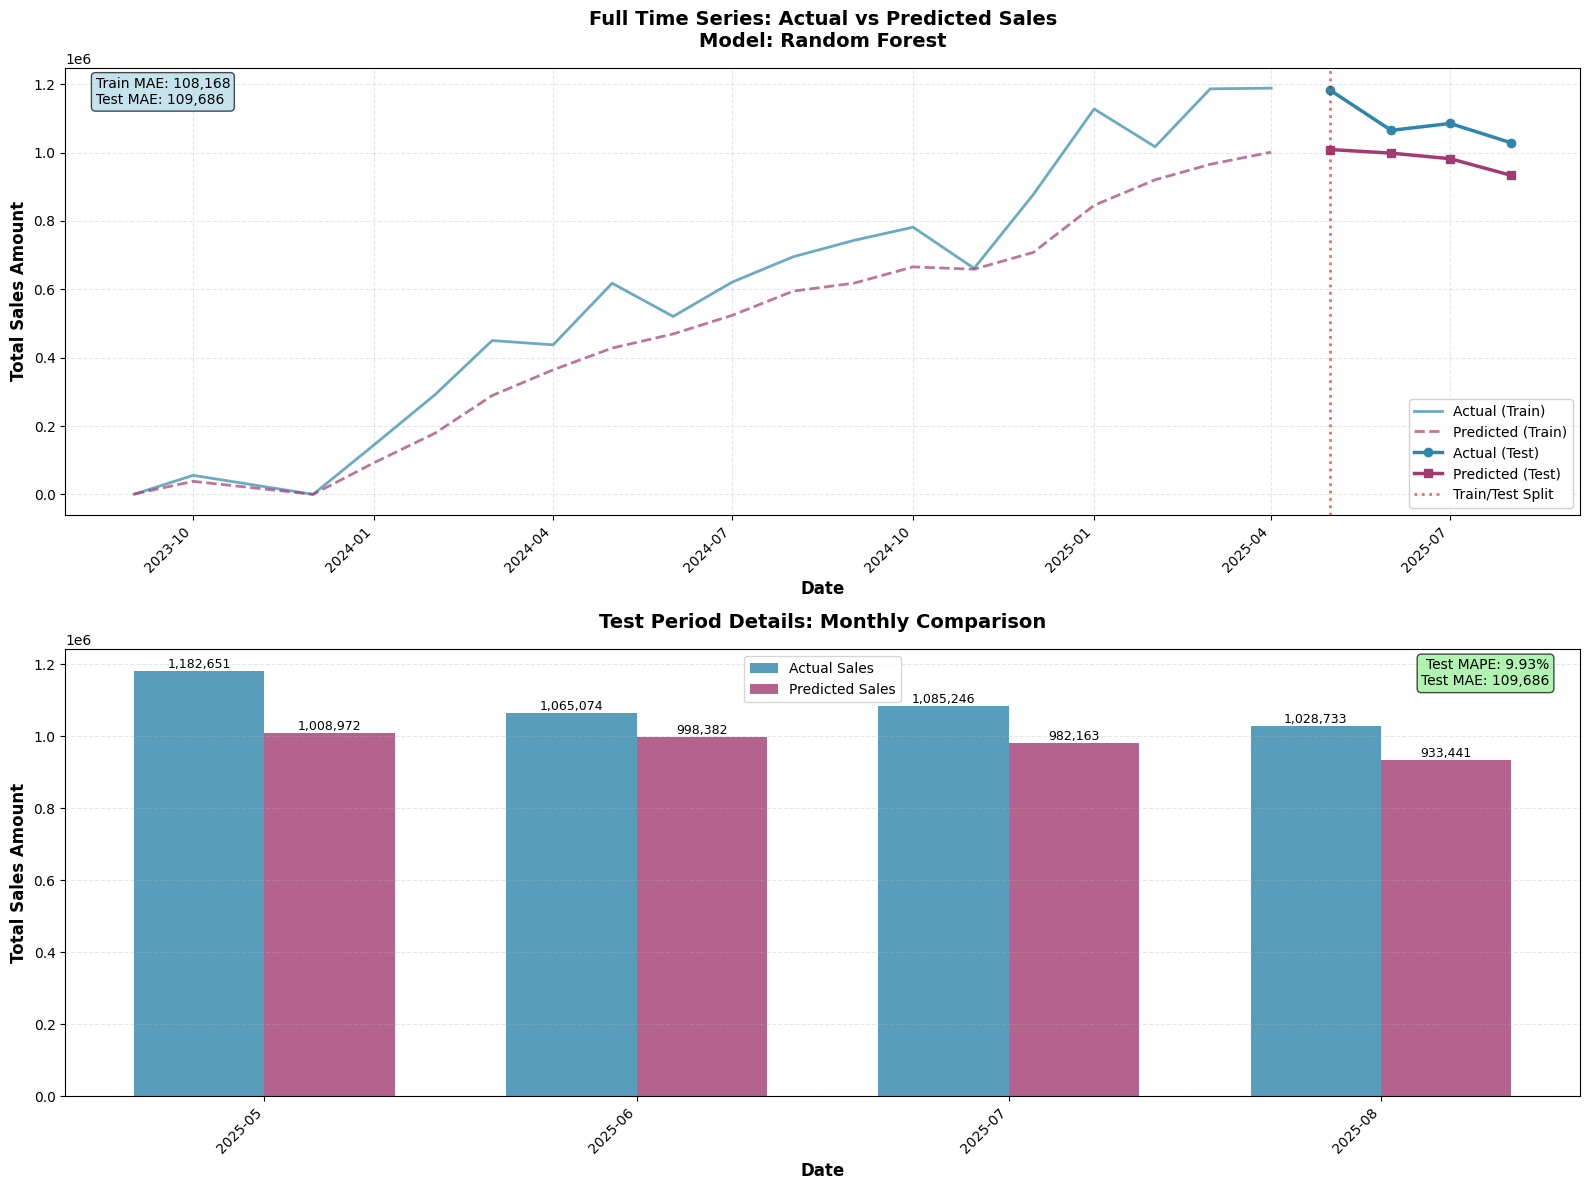


📊 FULL TIME SERIES STATISTICS:

🔵 TRAINING PERIOD (2023-09 to 2025-04):
   Total Actual Sales:      11,417,576.92
   Total Predicted Sales:    9,363,529.68
   Mean Absolute Error:        108,167.89
   Number of Months:                   19

🟣 TEST PERIOD (2025-05 to 2025-08):
   Total Actual Sales:       4,361,703.73
   Total Predicted Sales:    3,922,958.16
   Mean Absolute Error:        109,686.39
   Mean Absolute % Error:           9.93%
   Number of Months:                    4

📈 OVERALL DATASET:
   Total Time Points:                  23
   Date Range:            2023-09 to 2025-08


In [31]:
# Step 10: Plot actual vs predicted sales over FULL time period
time_series_results = plot_actual_vs_predicted_full(
    metadata,
    predictions,
    best_model,
    y_train,
    y_test
)

In [32]:
feature_cols = metadata['feature_cols']
corr_matrix = df_monthly[feature_cols].corr()
corr_pairs = (
    corr_matrix.where(~np.eye(corr_matrix.shape[0], dtype=bool))
    .stack()
    .rename("correlation")
    .sort_values(ascending=False)
)
# corr_pairs

In [33]:
top_10 = corr_pairs.head(30)
top_10

,,correlation
order_count_roll_median_2m,order_count_roll_max_2m,0.995495
order_count_roll_max_2m,order_count_roll_median_2m,0.995495
sales_amount_roll_median_2m,sales_amount_roll_max_2m,0.990969
sales_amount_roll_max_2m,sales_amount_roll_median_2m,0.990969
order_count_lag1,order_count_roll_median_2m,0.987811
order_count_roll_median_2m,order_count_lag1,0.987811
order_count_lag1,order_count_roll_max_2m,0.986723
order_count_roll_max_2m,order_count_lag1,0.986723
sales_amount_roll_median_2m,sales_amount_lag1,0.976746
sales_amount_lag1,sales_amount_roll_median_2m,0.976746



STEP 9: FEATURE IMPORTANCE - Random Forest

Top 10 Most Important Features:
   sales_amount_roll_median_2m                   0.144553
   order_count_roll_median_2m                    0.119993
   order_count_roll_max_2m                       0.096677
   group_hist_max                                0.087138
   sales_amount_roll_max_2m                      0.085425
   group_hist_med                                0.077968
   order_count_lag1                              0.065753
   sales_amount_lag1                             0.062371
   category_hist_med                             0.044791
   sales_trend                                   0.034458


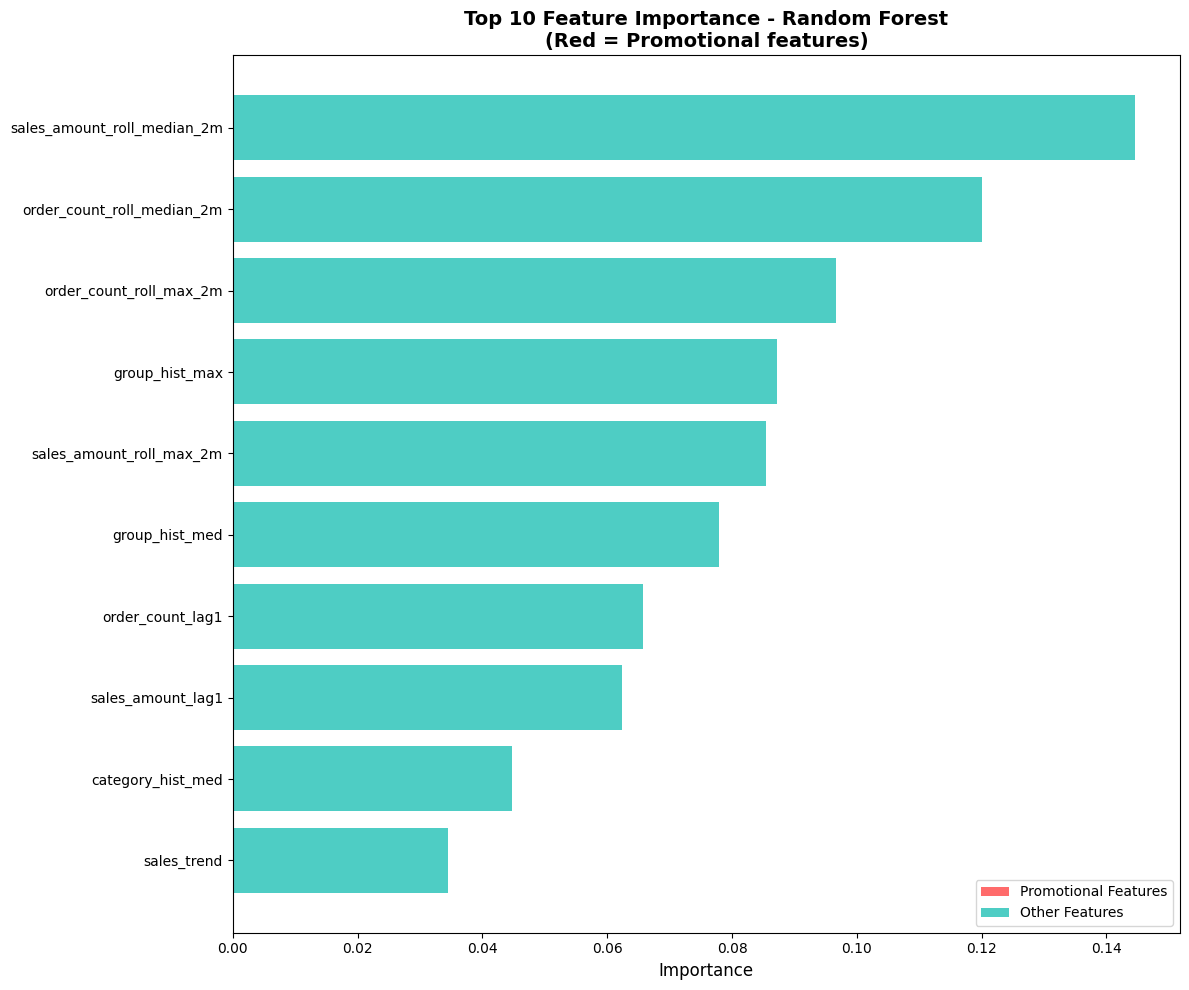

In [34]:
# Step 9: Feature importance
feat_importance = plot_feature_importance(
        models[best_model],
        metadata['feature_cols'],
        best_model,
        top_n=10
    )


In [35]:
# Correlation between order_count and sales_amount
corr_order_sales = df_monthly['order_count'].corr(df_monthly['sales_amount'])
print("Correlation (order_count vs sales_amount):", corr_order_sales)

# Correlation between sales_amount_lag1 and sales_amount
corr_saleslag_sales = df_monthly['sales_amount_lag1'].corr(df_monthly['sales_amount'])
print("Correlation (sales_amount_lag1 vs sales_amount):", corr_saleslag_sales)


Correlation (order_count vs sales_amount): 0.9450038602388514
Correlation (sales_amount_lag1 vs sales_amount): 0.9047992945387805
